In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../")
import os

from povertymapping.rollout_grids import get_region_filtered_bingtile_grids, compute_raster_stats
from povertymapping.hdx import get_hdx_file
from povertymapping.iso3 import get_iso3_code
from povertymapping.geoboundaries import get_geoboundaries
import geowrangler.vector_zonal_stats as vzs

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

/home/jace/workspace/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Set country-specific parameters

In [3]:
REGION = 'laos'
ADMIN_LVL = 'ADM2'
ZOOM_LEVEL = 14
GROUP_ZOOM_LEVEL = 8
country_code = get_iso3_code(REGION, code='alpha-2').lower()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


## Read bounds

In [4]:
bounds_file = get_geoboundaries(region=REGION, adm='ADM1')
bounds_gdf = gpd.read_file(bounds_file)
bounds_gdf = bounds_gdf.sort_values('shapeName')

In [5]:
bounds_gdf.sort_values('shapeName')#.explore()

,shapeISO,shapeName,shapeID,shapeGroup,shapeType,geometry
1,LA-AT,Attapeu,LAO-ADM1-3_0_0-B2,LAO,ADM1,"MULTIPOLYGON (((107.59147 14.87336, 107.59141 ..."
2,LA-BK,Bokeo,LAO-ADM1-3_0_0-B3,LAO,ADM1,"MULTIPOLYGON (((101.25529 20.18622, 101.25468 ..."
3,LA-BL,Bolikhamsai,LAO-ADM1-3_0_0-B4,LAO,ADM1,"MULTIPOLYGON (((105.25881 18.23862, 105.25859 ..."
4,LA-CH,Champasak,LAO-ADM1-3_0_0-B5,LAO,ADM1,"MULTIPOLYGON (((106.82797 15.01953, 106.82743 ..."
5,LA-HO,Houaphan,LAO-ADM1-3_0_0-B6,LAO,ADM1,"MULTIPOLYGON (((104.99274 20.09541, 104.99377 ..."
6,LA-KH,Khammouane,LAO-ADM1-3_0_0-B7,LAO,ADM1,"MULTIPOLYGON (((106.42514 17.02408, 106.42598 ..."
7,LA-LM,Luang Namtha,LAO-ADM1-3_0_0-B8,LAO,ADM1,"MULTIPOLYGON (((101.77623 21.12528, 101.77610 ..."
8,LA-LP,Luang Prabang,LAO-ADM1-3_0_0-B9,LAO,ADM1,"MULTIPOLYGON (((103.40047 20.78283, 103.39479 ..."
9,LA-OU,Oudomxay,LAO-ADM1-3_0_0-B10,LAO,ADM1,"MULTIPOLYGON (((102.35779 20.85826, 102.35774 ..."
10,LA-PH,Phongsaly,LAO-ADM1-3_0_0-B11,LAO,ADM1,"MULTIPOLYGON (((102.99287 21.59014, 102.99283 ..."


## Read reference data

In [6]:
data_df = pd.read_csv("./la-iwi-2020.csv")
data_df = bounds_gdf.merge(data_df, left_on='shapeName', right_on='province_name', how='left')
data_df['rank'] = data_df['mean_iwi_2020'].rank(ascending=False)
data_df

,shapeISO,shapeName,shapeID,shapeGroup,shapeType,geometry,province_name,mean_iwi_2020,rank
0,LA-AT,Attapeu,LAO-ADM1-3_0_0-B2,LAO,ADM1,"MULTIPOLYGON (((107.59147 14.87336, 107.59141 ...",Attapeu,74.7,10.0
1,LA-BK,Bokeo,LAO-ADM1-3_0_0-B3,LAO,ADM1,"MULTIPOLYGON (((101.25529 20.18622, 101.25468 ...",Bokeo,79.8,6.0
2,LA-BL,Bolikhamsai,LAO-ADM1-3_0_0-B4,LAO,ADM1,"MULTIPOLYGON (((105.25881 18.23862, 105.25859 ...",Bolikhamsai,87.4,2.0
3,LA-CH,Champasak,LAO-ADM1-3_0_0-B5,LAO,ADM1,"MULTIPOLYGON (((106.82797 15.01953, 106.82743 ...",Champasak,82.5,5.0
4,LA-HO,Houaphan,LAO-ADM1-3_0_0-B6,LAO,ADM1,"MULTIPOLYGON (((104.99274 20.09541, 104.99377 ...",Houaphan,64.6,16.0
5,LA-KH,Khammouane,LAO-ADM1-3_0_0-B7,LAO,ADM1,"MULTIPOLYGON (((106.42514 17.02408, 106.42598 ...",Khammouane,77.1,8.0
6,LA-LM,Luang Namtha,LAO-ADM1-3_0_0-B8,LAO,ADM1,"MULTIPOLYGON (((101.77623 21.12528, 101.77610 ...",Luang Namtha,73.2,11.0
7,LA-LP,Luang Prabang,LAO-ADM1-3_0_0-B9,LAO,ADM1,"MULTIPOLYGON (((103.40047 20.78283, 103.39479 ...",Luang Prabang,68.3,14.0
8,LA-OU,Oudomxay,LAO-ADM1-3_0_0-B10,LAO,ADM1,"MULTIPOLYGON (((102.35779 20.85826, 102.35774 ...",Oudomxay,72.1,12.0
9,LA-PH,Phongsaly,LAO-ADM1-3_0_0-B11,LAO,ADM1,"MULTIPOLYGON (((102.99287 21.59014, 102.99283 ...",Phongsaly,66.4,15.0


## Read and process model output

In [7]:
!ls

1_la_compare_rank_province.ipynb  la-iwi-2020.csv


In [8]:
out_gdf = gpd.read_file("../../../data/results/la/2023-02-21-la-rollout-output.geojson")
out_gdf.head()#explore(column='Predicted Relative Wealth Index')

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,Predicted Relative Wealth Index,Predicted Wealth Category (quintile),geometry
0,13220113003212,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,1139.814456,0.536201,A,"POLYGON ((100.06348 20.34463, 100.06348 20.365..."
1,13220113003211,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,18.897820,0.501414,A,"POLYGON ((100.08545 20.36523, 100.08545 20.385..."
2,13220113003213,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,467.272466,0.624173,A,"POLYGON ((100.08545 20.34463, 100.08545 20.365..."
3,13220113003231,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,457.210483,0.614294,A,"POLYGON ((100.08545 20.32402, 100.08545 20.344..."
4,13220113003233,Tonpheung,None,LAO-ADM2-3_0_0-B114,LAO,ADM2,484.636913,0.557349,A,"POLYGON ((100.08545 20.30342, 100.08545 20.324..."


In [10]:
# get stats for provinces (ADM1)
out_gdf = vzs.create_zonal_stats(
    bounds_gdf,
    out_gdf,
    overlap_method="intersects",
    aggregations=[{"column":'Predicted Relative Wealth Index', "func": "mean", "output":"model_wealth_index_mean"}]
)
out_gdf['rank'] = out_gdf["model_wealth_index_mean"].rank(ascending=False)
out_gdf

,shapeISO,shapeName,shapeID,shapeGroup,shapeType,geometry,model_wealth_index_mean,rank
1,LA-AT,Attapeu,LAO-ADM1-3_0_0-B2,LAO,ADM1,"MULTIPOLYGON (((107.59147 14.87336, 107.59141 ...",0.255860,16.0
2,LA-BK,Bokeo,LAO-ADM1-3_0_0-B3,LAO,ADM1,"MULTIPOLYGON (((101.25529 20.18622, 101.25468 ...",0.281993,6.0
3,LA-BL,Bolikhamsai,LAO-ADM1-3_0_0-B4,LAO,ADM1,"MULTIPOLYGON (((105.25881 18.23862, 105.25859 ...",0.294027,3.0
4,LA-CH,Champasak,LAO-ADM1-3_0_0-B5,LAO,ADM1,"MULTIPOLYGON (((106.82797 15.01953, 106.82743 ...",0.284149,5.0
5,LA-HO,Houaphan,LAO-ADM1-3_0_0-B6,LAO,ADM1,"MULTIPOLYGON (((104.99274 20.09541, 104.99377 ...",0.256109,15.0
6,LA-KH,Khammouane,LAO-ADM1-3_0_0-B7,LAO,ADM1,"MULTIPOLYGON (((106.42514 17.02408, 106.42598 ...",0.289663,4.0
7,LA-LM,Luang Namtha,LAO-ADM1-3_0_0-B8,LAO,ADM1,"MULTIPOLYGON (((101.77623 21.12528, 101.77610 ...",0.273791,7.0
8,LA-LP,Luang Prabang,LAO-ADM1-3_0_0-B9,LAO,ADM1,"MULTIPOLYGON (((103.40047 20.78283, 103.39479 ...",0.260783,12.0
9,LA-OU,Oudomxay,LAO-ADM1-3_0_0-B10,LAO,ADM1,"MULTIPOLYGON (((102.35779 20.85826, 102.35774 ...",0.260721,13.0
10,LA-PH,Phongsaly,LAO-ADM1-3_0_0-B11,LAO,ADM1,"MULTIPOLYGON (((102.99287 21.59014, 102.99283 ...",0.254187,17.0


## Compare model output vs reference

In [11]:
compare_gdf = out_gdf[['shapeISO','shapeName','model_wealth_index_mean','rank', 'geometry']].merge(\
                    data_df[['shapeISO','shapeName','mean_iwi_2020','rank']], on='shapeISO', how='outer', suffixes=['_model', '_reference'])#.dropna()
compare_gdf

,shapeISO,shapeName_model,model_wealth_index_mean,rank_model,geometry,shapeName_reference,mean_iwi_2020,rank_reference
0,LA-AT,Attapeu,0.255860,16.0,"MULTIPOLYGON (((107.59147 14.87336, 107.59141 ...",Attapeu,74.7,10.0
1,LA-BK,Bokeo,0.281993,6.0,"MULTIPOLYGON (((101.25529 20.18622, 101.25468 ...",Bokeo,79.8,6.0
2,LA-BL,Bolikhamsai,0.294027,3.0,"MULTIPOLYGON (((105.25881 18.23862, 105.25859 ...",Bolikhamsai,87.4,2.0
3,LA-CH,Champasak,0.284149,5.0,"MULTIPOLYGON (((106.82797 15.01953, 106.82743 ...",Champasak,82.5,5.0
4,LA-HO,Houaphan,0.256109,15.0,"MULTIPOLYGON (((104.99274 20.09541, 104.99377 ...",Houaphan,64.6,16.0
5,LA-KH,Khammouane,0.289663,4.0,"MULTIPOLYGON (((106.42514 17.02408, 106.42598 ...",Khammouane,77.1,8.0
6,LA-LM,Luang Namtha,0.273791,7.0,"MULTIPOLYGON (((101.77623 21.12528, 101.77610 ...",Luang Namtha,73.2,11.0
7,LA-LP,Luang Prabang,0.260783,12.0,"MULTIPOLYGON (((103.40047 20.78283, 103.39479 ...",Luang Prabang,68.3,14.0
8,LA-OU,Oudomxay,0.260721,13.0,"MULTIPOLYGON (((102.35779 20.85826, 102.35774 ...",Oudomxay,72.1,12.0
9,LA-PH,Phongsaly,0.254187,17.0,"MULTIPOLYGON (((102.99287 21.59014, 102.99283 ...",Phongsaly,66.4,15.0


In [12]:
data = compare_gdf.dropna()
coef, p = spearmanr(data['mean_iwi_2020'], data['model_wealth_index_mean'])
print(f'The spearman rank correlation is: {coef:.4f}')

The spearman rank correlation is: 0.7525


## Heatmap

In [13]:
def despine(ax):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

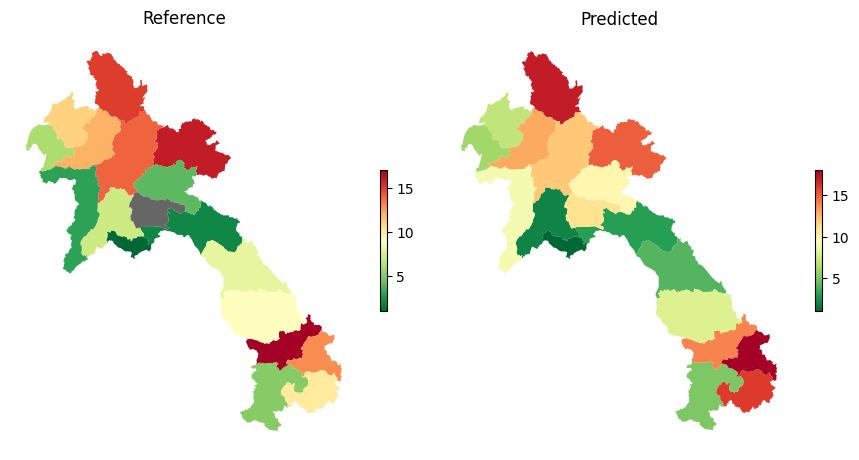

In [14]:
fig, axs = plt.subplots(1,2, figsize=(9,5))

compare_gdf.plot(
    column='rank_reference',
    ax=axs[0],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3},
    missing_kwds={
        "color": "0.4",
        "label": "Missing values",
    }
)
despine(axs[0])

compare_gdf.plot(
    column='rank_model',
    ax=axs[1],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3},
    missing_kwds={
        "color": "0.4",
        "label": "Missing values",
    }
)

despine(axs[1])
axs[0].set_title('Reference')
axs[1].set_title('Predicted')
# leg1 = axs[0].get_legend()
# leg1.set_title("Rank")
# leg2 = axs[1].get_legend()
# leg2.set_title("Rank")# 
#fig.suptitle('Wealth index rank')
fig.tight_layout()